# Analysis of Church Farm weekly sampling data 

Looking at specific pathogens over time, working in 24hr_env

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from matplotlib.dates import DateFormatter
from matplotlib.dates import HourLocator
from scipy.stats import sem

## Reading in data 

- Taxa counts from MARTi (Summed counts)[Script](https://github.com/Mia-FGB/data_processing/blob/main/split_marti_taxa.pys)
- Clean metadata file generated in `metadata_exploration.ipynb`
- Read numbers from the MARTi JSON [Script](https://github.com/Mia-FGB/data_processing/blob/main/get_read_number_from_json.py)


In [16]:
summed_marti = pd.read_csv('/Users/berelsom/Library/CloudStorage/OneDrive-NorwichBioScienceInstitutes/Air_Samples/Church_farm/all_data_mar25_summed.tsv', sep='\t')
summed_marti

,Name,NCBI ID,NCBI Rank,ChurchFarm1_Jul24,ChurchFarm1_Oct24,ChurchFarm2_Jul24,ChurchFarm2_Oct24,June_10_12_1,June_10_12_2,May_10_12_1,...,Reg_5_210224,Reg_65_Neg,Reg_6_011222,Reg_6_210224,Reg_7_010123,Reg_7_270224,Reg_8_010123,Reg_8_270224,Reg_9_010223,Reg_9_060324
0,unclassified,0,no rank,117181,152309,125507,153143,95323,86727,155626,...,100542,0,67227,95103,39000,106048,21150,108371,72912,121342
1,root,1,no rank,192224,191508,190692,192407,190599,189932,193063,...,189802,2,109050,190811,42623,189679,22141,190798,160760,191038
2,Bacteria,2,superkingdom,8859,5205,10274,4953,16361,13324,3008,...,20066,1,38072,21088,2762,41178,148,50528,87783,20277
3,Cellvibrio,10,genus,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Phenylobacterium,20,genus,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3035,Terrabacter sp. C0L_2,3108389,species,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3036,Lentzea sp. DG1S-22,3108822,species,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3037,Novosphingobium sp. RL4,3109595,species,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3038,Ralstonia solanacearum species complex,3116862,species group,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
read_numbers = pd.read_csv("/Users/berelsom/Library/CloudStorage/OneDrive-NorwichBioScienceInstitutes/Air_Samples/Church_farm/metadata/read_numbers.tsv", sep="\t")
read_numbers.rename(columns={"ID": "Sample_ID"}, inplace=True)

In [13]:
meta = pd.read_csv("/Users/berelsom/Library/CloudStorage/OneDrive-NorwichBioScienceInstitutes/Air_Samples/Church_farm/metadata/metadata_cleaned.tsv", sep="\t")
#Convert to datetime
meta['DateTime_UTC'] = pd.to_datetime(meta['DateTime_UTC'])

Merge the data

In [ ]:
#Melt the data to long
marti_long = summed_marti.melt(
    id_vars = ['Name', 'NCBI ID', 'NCBI Rank'],           # the columns we want to keep
    var_name = 'Sample_ID',    # the name of the new column with old column names (to contain the cols we are combining)
    value_name = 'read count' # the name of the new column with old column values
)

# Merge the metadata with the long data
marti_meta = marti_long.merge(meta, on='Sample_ID', how='inner')

# #Merge the read numbers on Sample and ID
marti_meta = marti_meta.merge(read_numbers, on='Sample_ID')
marti_meta

# Check if any samples are lost
# marti_meta['Sample_ID'].nunique() # Should be 105
# lost_samples = set(marti_long['Sample_ID']) - set(marti_meta['Sample_ID'])
# print(f"Lost samples: {lost_samples}")


105

Calculate HPM

In [ ]:
# Calculate various metrics and add them as new columns
metrics = {
    'Relative Abundance': lambda row: row['read count'] / row['ReadsPassBasecall'] * 100,
    'Log Relative Abundance': lambda row: np.log(row['ReadsPassBasecall'] + 1),
    'HP100k': lambda row: (row['read count'] / row['ReadsPassBasecall']) * 100000,
    'Log HP100k': lambda row: np.log((row['read count'] / row['ReadsPassBasecall']) * 100000 + 1),
    'HPM': lambda row: (row['read count'] / row['ReadsPassBasecall']) * 1000000,
    'Log HPM': lambda row: np.log((row['read count'] / row['ReadsPassBasecall']) * 1000000)
}

for metric, func in metrics.items():
    marti_meta[metric] = marti_meta.apply(func, axis=1)

# Replace the -inf values with 0 for 'Log HPM'
marti_meta['Log HPM'] = marti_meta['Log HPM'].replace(-np.inf, 0)

/var/folders/ns/9skdzql508n7rzzgbqpc2wpw000f7r/T/ipykernel_13263/98867714.py:8: RuntimeWarning: divide by zero encountered in log
  'Log HPM': lambda row: np.log((row['read count'] / row['ReadsPassBasecall']) * 1000000)


Index(['Name', 'NCBI ID', 'NCBI Rank', 'Sample_ID', 'read count',
       'Sampler_Used', 'Notes', 'Location', 'Year', 'BST_GMT',
       'Date_Collected', 'Missing_Date', 'Missing_Time', 'Start_Time',
       'End_Time', 'Collection_Length_Min', 'DNA_Concentration_(ng/ul)', 'WGA',
       'DNA_Concentration_WGA_(ng/ul)', 'Location_96_well_plate', 'Barcode_x',
       'DateTime_UTC', 'Repeat', 'Nice_ID', 'Sample', 'Barcode_y', 'RunID',
       'ReadsPassBasecall', 'ReadsFailedFilter', 'ReadsPassedFilter',
       'ReadsWithClassification', 'ReadsUnclassified', 'ClassifiedYield',
       'UnclassifiedYield', 'ReadsWithPoorAlignments', 'ReadsAnalysed',
       'Relative Abundance', 'Log Relative Abundance', 'HP100k', 'Log HP100k',
       'HPM', 'Log HPM'],
      dtype='object')

## Pathogens 
 Specifically looking at 9 pathogens and how they behave 
 - Puccinia, Blumeria, Fusarium, Zymoseptoria, Ustilago, Magnaporthe, Pyrenophora, Claviceps, Parastagonospora / Phaeosphaeria
- Collapse summed reads to genus level & Filter to just these pathogens

In [28]:
pathogen_genera = ["Puccinia", "Blumeria", "Fusarium", "Zymoseptoria", "Ustilago", "Magnaporthe",
                    "Claviceps", "Pyrenophora", "Parastagonospora", "Phaeosphaeria"]

pathogen_reads  = marti_meta[(marti_meta['NCBI Rank'] == 'genus') &
                           (marti_meta['Name'].isin(pathogen_genera))]
pathogen_reads

,Name,NCBI ID,NCBI Rank,Sample_ID,read count,Sampler_Used,Notes,Location,Year,BST_GMT,...,ClassifiedYield,UnclassifiedYield,ReadsWithPoorAlignments,ReadsAnalysed,Relative Abundance,Log Relative Abundance,HP100k,Log HP100k,HPM,Log HPM
364,Pyrenophora,5027,genus,ChurchFarm1_Jul24,1115,Kitty,July Norfolk seq,"52.626065, 1.179749",2024,BST,...,115205194,136612934,17213,192224,0.5575,12.206078,557.5,6.325255,5575.0,8.626048
404,Ustilago,5269,genus,ChurchFarm1_Jul24,321,Kitty,July Norfolk seq,"52.626065, 1.179749",2024,BST,...,115205194,136612934,17213,192224,0.1605,12.206078,160.5,5.084505,1605.0,7.380879
409,Puccinia,5296,genus,ChurchFarm1_Jul24,262,Kitty,July Norfolk seq,"52.626065, 1.179749",2024,BST,...,115205194,136612934,17213,192224,0.1310,12.206078,131.0,4.882802,1310.0,7.177782
443,Fusarium,5506,genus,ChurchFarm1_Jul24,122,Kitty,July Norfolk seq,"52.626065, 1.179749",2024,BST,...,115205194,136612934,17213,192224,0.0610,12.206078,61.0,4.127134,610.0,6.413459
752,Blumeria,34372,genus,ChurchFarm1_Jul24,0,Kitty,July Norfolk seq,"52.626065, 1.179749",2024,BST,...,115205194,136612934,17213,192224,0.0000,12.206078,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316569,Puccinia,5296,genus,Reg_9_060324,70,Collins,NaN,"52.626065, 1.179749",2024,GMT,...,93334417,128078273,16251,191040,0.0350,12.206078,35.0,3.583519,350.0,5.857933
316603,Fusarium,5506,genus,Reg_9_060324,84,Collins,NaN,"52.626065, 1.179749",2024,GMT,...,93334417,128078273,16251,191040,0.0420,12.206078,42.0,3.761200,420.0,6.040255
316912,Blumeria,34372,genus,Reg_9_060324,140,Collins,NaN,"52.626065, 1.179749",2024,GMT,...,93334417,128078273,16251,191040,0.0700,12.206078,70.0,4.262680,700.0,6.551080
318208,Zymoseptoria,1047167,genus,Reg_9_060324,392,Collins,NaN,"52.626065, 1.179749",2024,GMT,...,93334417,128078273,16251,191040,0.1960,12.206078,196.0,5.283204,1960.0,7.580700


Plotting a line graph with all the pathogens faceted into one figure 

- Try seperate 2023 & 2024
- Try 2023 & 2024 on the same axis overlayed

/Users/berelsom/opt/anaconda3/envs/24hr_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/berelsom/opt/anaconda3/envs/24hr_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/berelsom/opt/anaconda3/envs/24hr_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/berelsom/opt/anaconda3/envs/24hr_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: us

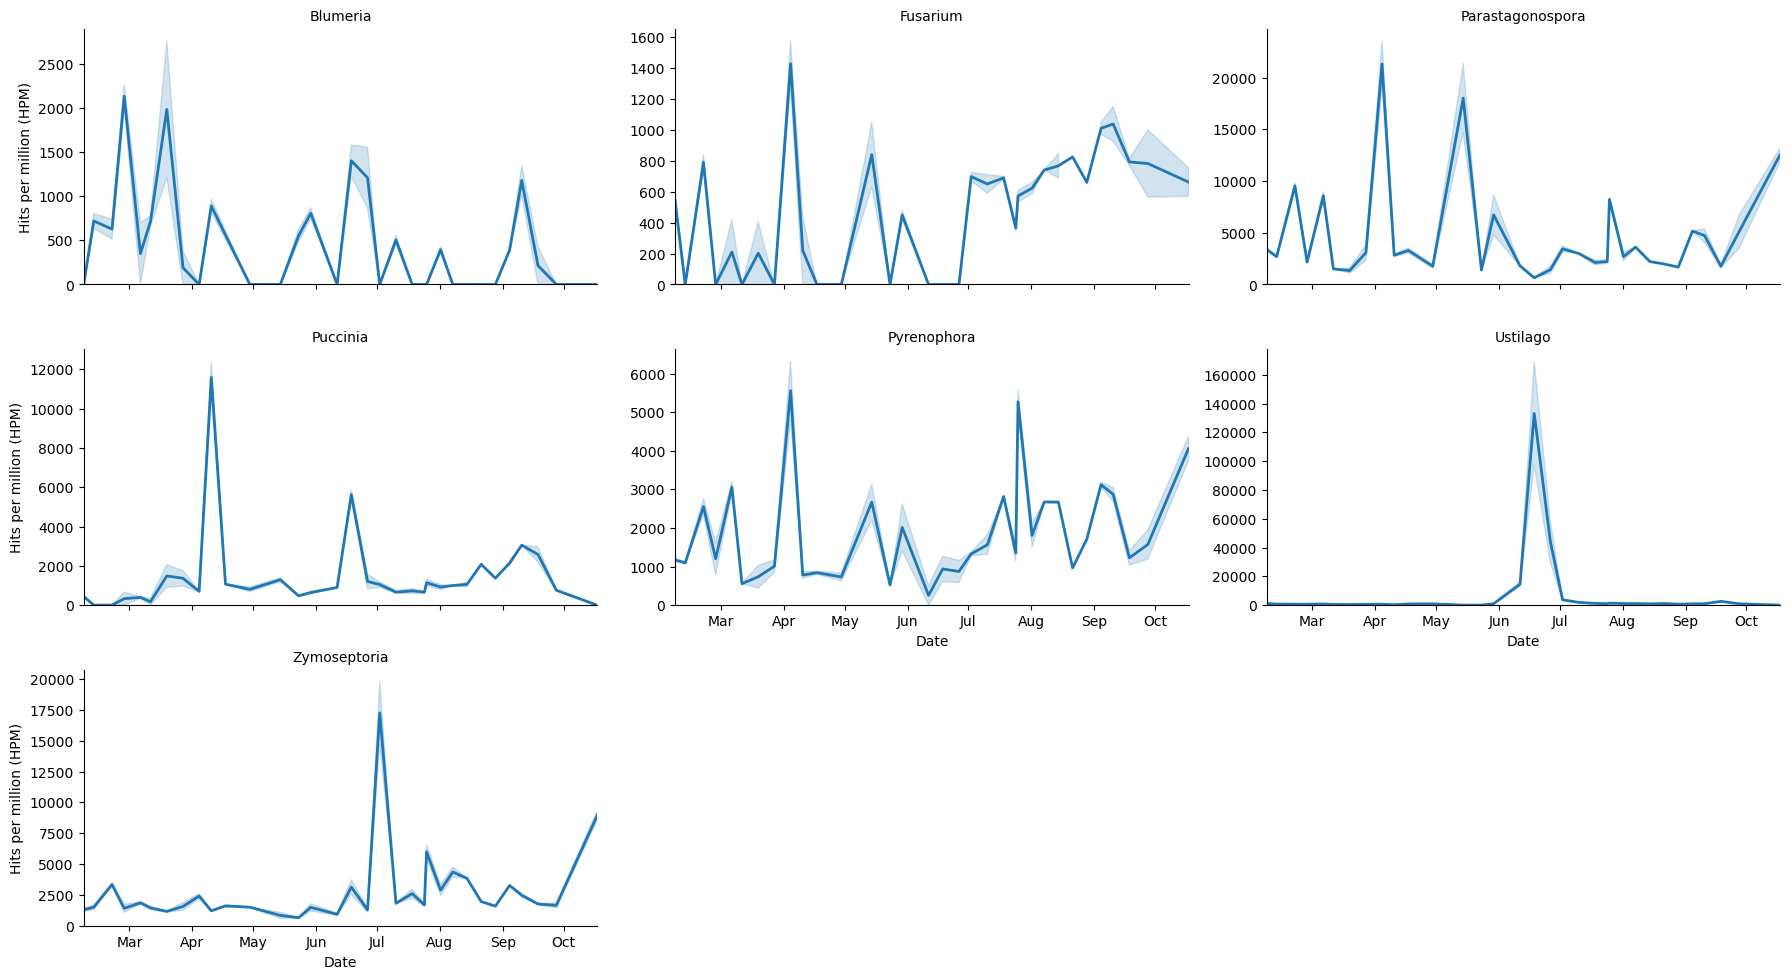

In [51]:
# Filter the data for June / May
pathogen_24 = pathogen_reads[(pathogen_reads['Year'] == 2024)]
pathogen_22_23 = pathogen_reads[(pathogen_reads['Year'] == 2022) | (pathogen_reads['Year'] == 2023)]

#Choose one of the three filters to plot one at a time 
# fungi_species_filter = pathogen_22_23
fungi_species_filter = pathogen_24

# Sort species alphabetically
sorted_genus = fungi_species_filter['Name'].sort_values().unique()

# Get the time range of your data
min_time = fungi_species_filter['DateTime_UTC'].min()
max_time = fungi_species_filter['DateTime_UTC'].max() + pd.Timedelta(hours=1)

# Create a FacetGrid with scatter plots for points and line plots to connect them, faceted by species / Genus
g = sns.FacetGrid(
    fungi_species_filter,
    col="Name",
    col_wrap=3,
    col_order=sorted_genus,
    sharey=False, 
    height = 3,
    aspect = 2,
)

# Create line plots within each facet (connecting lines)
g.map_dataframe(
    sns.lineplot,
    x="DateTime_UTC", 
    y="HPM",
    linewidth=2  # Set the desired line width
)

# Set x-axis properties for each subplot
g.set_axis_labels("Date", "Hits per million (HPM)")
g.set_titles("{col_name}", fontweight = 'medium', fontsize = 50)  # Set titles based on species

# make y-axis have 0 at the bottom
for ax, genus in zip(g.axes.flat, sorted_genus):
    ax.set_ylim(bottom=0)  # Ensure the y-axis starts at 0

# Set x-axis properties for all subplots
for ax in g.axes.flat:
    ax.xaxis.set_major_locator(mdates.MonthLocator())  # Set monthly intervals
    ax.xaxis.set_major_formatter(DateFormatter('%b'))  # Format x-axis to show abbreviated month names

    # Set x-axis limits from min_time to max_time
    ax.set_xlim([min_time, max_time])

# Set the size of the entire figure
g.fig.set_size_inches(18, 10)

# Save the figure - change name depending on year
plt.savefig(
    "/Users/berelsom/Library/CloudStorage/OneDrive-NorwichBioScienceInstitutes/Air_Samples/Church_farm/Graphs/pathogen_graphs/All_2024.svg")

Both years on the same graph

In [54]:
pathogen_reads['DateTime_Without_Year'] = pathogen_reads['DateTime_UTC'].apply(lambda x: x.replace(year=1900))
pathogen_reads

/var/folders/ns/9skdzql508n7rzzgbqpc2wpw000f7r/T/ipykernel_13263/4259393555.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pathogen_reads['DateTime_Without_Year'] = pathogen_reads['DateTime_UTC'].apply(lambda x: x.replace(year=1900))


,Name,NCBI ID,NCBI Rank,Sample_ID,read count,Sampler_Used,Notes,Location,Year,BST_GMT,...,UnclassifiedYield,ReadsWithPoorAlignments,ReadsAnalysed,Relative Abundance,Log Relative Abundance,HP100k,Log HP100k,HPM,Log HPM,DateTime_Without_Year
364,Pyrenophora,5027,genus,ChurchFarm1_Jul24,1115,Kitty,July Norfolk seq,"52.626065, 1.179749",2024,BST,...,136612934,17213,192224,0.5575,12.206078,557.5,6.325255,5575.0,8.626048,1900-07-25 11:03:00
404,Ustilago,5269,genus,ChurchFarm1_Jul24,321,Kitty,July Norfolk seq,"52.626065, 1.179749",2024,BST,...,136612934,17213,192224,0.1605,12.206078,160.5,5.084505,1605.0,7.380879,1900-07-25 11:03:00
409,Puccinia,5296,genus,ChurchFarm1_Jul24,262,Kitty,July Norfolk seq,"52.626065, 1.179749",2024,BST,...,136612934,17213,192224,0.1310,12.206078,131.0,4.882802,1310.0,7.177782,1900-07-25 11:03:00
443,Fusarium,5506,genus,ChurchFarm1_Jul24,122,Kitty,July Norfolk seq,"52.626065, 1.179749",2024,BST,...,136612934,17213,192224,0.0610,12.206078,61.0,4.127134,610.0,6.413459,1900-07-25 11:03:00
752,Blumeria,34372,genus,ChurchFarm1_Jul24,0,Kitty,July Norfolk seq,"52.626065, 1.179749",2024,BST,...,136612934,17213,192224,0.0000,12.206078,0.0,0.000000,0.0,0.000000,1900-07-25 11:03:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316569,Puccinia,5296,genus,Reg_9_060324,70,Collins,NaN,"52.626065, 1.179749",2024,GMT,...,128078273,16251,191040,0.0350,12.206078,35.0,3.583519,350.0,5.857933,1900-03-06 10:20:00
316603,Fusarium,5506,genus,Reg_9_060324,84,Collins,NaN,"52.626065, 1.179749",2024,GMT,...,128078273,16251,191040,0.0420,12.206078,42.0,3.761200,420.0,6.040255,1900-03-06 10:20:00
316912,Blumeria,34372,genus,Reg_9_060324,140,Collins,NaN,"52.626065, 1.179749",2024,GMT,...,128078273,16251,191040,0.0700,12.206078,70.0,4.262680,700.0,6.551080,1900-03-06 10:20:00
318208,Zymoseptoria,1047167,genus,Reg_9_060324,392,Collins,NaN,"52.626065, 1.179749",2024,GMT,...,128078273,16251,191040,0.1960,12.206078,196.0,5.283204,1960.0,7.580700,1900-03-06 10:20:00


/Users/berelsom/opt/anaconda3/envs/24hr_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/berelsom/opt/anaconda3/envs/24hr_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/berelsom/opt/anaconda3/envs/24hr_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/berelsom/opt/anaconda3/envs/24hr_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: us

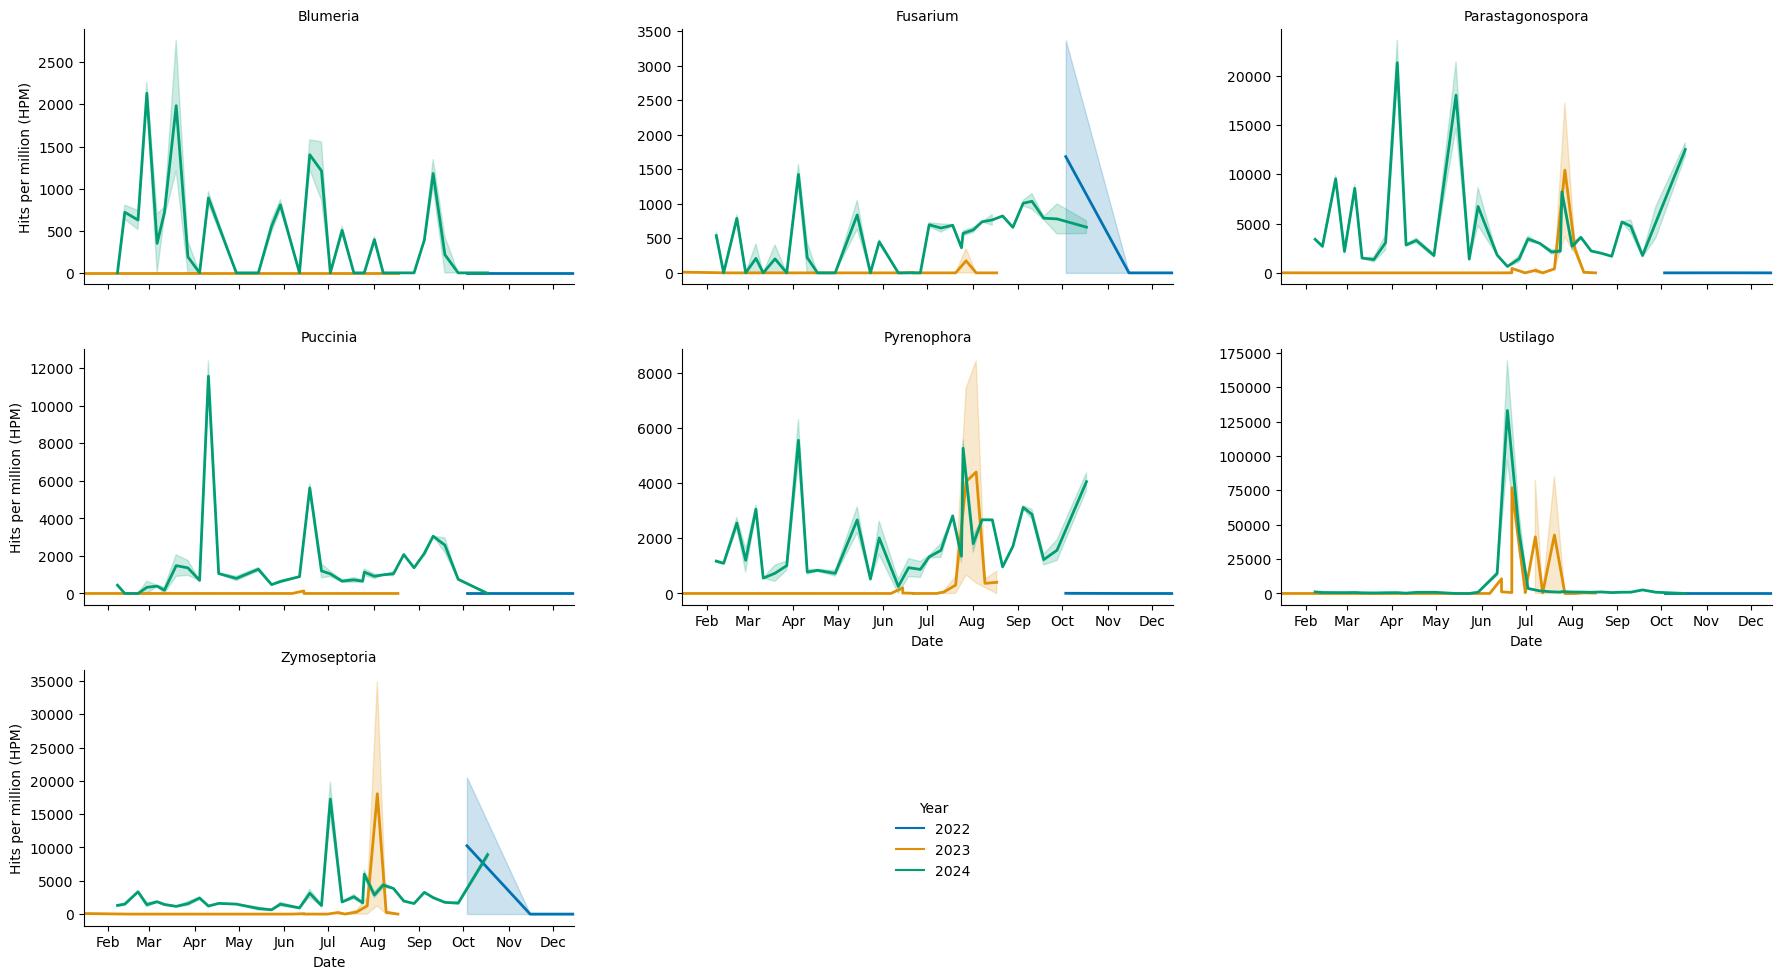

In [73]:
fungi_species_filter = pathogen_reads

# Sort species alphabetically
sorted_genus = fungi_species_filter['Name'].sort_values().unique()

# Get the time range of your data
min_time = fungi_species_filter['DateTime_Without_Year'].min()
max_time = fungi_species_filter['DateTime_Without_Year'].max() + pd.Timedelta(hours=1)

# Create a FacetGrid with scatter plots for points and line plots to connect them, faceted by species / Genus
g = sns.FacetGrid(
    fungi_species_filter,
    col="Name",
    col_wrap=3,
    col_order=sorted_genus,
    sharey=False, 
    height = 3,
    aspect = 2,
)

# Create line plots within each facet (connecting lines)
g.map_dataframe(
    sns.lineplot,
    x='DateTime_Without_Year', 
    y="HPM",
    linewidth=2,  # Set the desired line width
    hue="Year",
    palette="colorblind",
    hue_order=[2022, 2023, 2024],
    legend="full",  # Show legend for hue
)

# Set x-axis properties for each subplot
g.set_axis_labels("Date", "Hits per million (HPM)")
g.set_titles("{col_name}", fontweight = 'medium', fontsize = 50)  # Set titles based on species

# Set x-axis properties for all subplots
for ax in g.axes.flat:
    ax.xaxis.set_major_locator(mdates.MonthLocator())  # Set monthly intervals
    ax.xaxis.set_major_formatter(DateFormatter('%b'))  # Format x-axis to show abbreviated month names

    # Set x-axis limits from min_time to max_time
    ax.set_xlim([min_time, max_time])

# Set the size of the entire figure
g.fig.set_size_inches(18, 10)
g.add_legend(title="Year", loc="lower center", bbox_to_anchor=(0.5, 0.1))

# Set the font size for everything
plt.rcParams.update({'font.size': 10})

# Save the figure - change name depending on year
plt.savefig(
    "/Users/berelsom/Library/CloudStorage/OneDrive-NorwichBioScienceInstitutes/Air_Samples/Church_farm/Graphs/pathogen_graphs/All_years_pathogens_line.svg")

Get time ranges for the weather data to be plotted and have matching axis

In [74]:
# Get the time range of your data
min_time = fungi_species_filter['DateTime_Without_Year'].min()
max_time = fungi_species_filter['DateTime_Without_Year'].max() + pd.Timedelta(hours=1)

print(f"Min time: {min_time}")
print(f"Max time: {max_time}")


Min time: 1900-01-15 10:00:00
Max time: 1900-12-15 11:00:00
